# Image to text pipeline

In [109]:
import nbimporter

import Preprocessing_Final_Project as preprocessing
#from nlp_sentence import correct
import cv2
import imutils
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import re
from collections import Counter
#from ipynb.fs.full.Preprocessing_Final_Project import word_segment

In [110]:
image = 'emnist_words/word2.png'
#plt.imshow(image)
#image = cv2.imread(image)
#image.shape

In [111]:
#input an image file
#output is an array of each segmented image, in a np array for use in neural network prediction
def word_segment(image_file):
    # load the input image from disk, convert it to grayscale, and blur
    # it to reduce noise
    image = cv2.imread(image_file)
    #image = cv2.resize(image, (140, 28))
    scale_f = 1.4
    image = cv2.resize(image, (int(image.shape[1]*scale_f), int(image.shape[0]*scale_f)))

    plt.show(image_file)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # initialize the list of contour bounding boxes and associated
    # characters that we'll be OCR'ing
    chars = []
    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # filter out bounding boxes, ensuring they are neither too small
        # nor too large
        if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
            # extract the character and threshold it to make the character
            # appear as *white* (foreground) on a *black* background, then
            # grab the width and height of the thresholded image
            roi = gray[y:y + h, x:x + w]
            thresh = cv2.threshold(roi, 0, 255,
                cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            (tH, tW) = thresh.shape
            # if the width is greater than the height, resize along the
            # width dimension
            if tW > tH:
                thresh = imutils.resize(thresh, width=28)
            # otherwise, resize along the height
            else:
                thresh = imutils.resize(thresh, height=28)
        # re-grab the image dimensions (now that its been resized)
            # and then determine how much we need to pad the width and
            # height such that our image will be 32x32
            (tH, tW) = thresh.shape
            dX = int(max(0, 28 - tW) / 2.0)
            dY = int(max(0, 28 - tH) / 2.0)
            # pad the image and force 32x32 dimensions
            padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
                left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
                value=(0, 0, 0))
            padded = cv2.resize(padded, (28, 28))
            # prepare the padded image for classification via our
            # handwriting OCR model
            padded = padded.astype("float32") / 255.0
            padded = np.expand_dims(padded, axis=-1)
            # update our list of characters that will be OCR'd
            chars.append((padded, (x, y, w, h)))

            # extract the bounding box locations and padded characters
    boxes = [b[1] for b in chars]
    chars = np.array([c[0] for c in chars], dtype="float32")
    return chars

In [112]:
chars = word_segment(image)
print(chars.shape)

(6, 28, 28, 1)


In [113]:
# Map classes from class number to character value
class_map = {}
#with open("emnist-letters-mapping.txt") as file:
#    for line in file:
#        (key, value) = line.split()
#        class_map[int(key)] = chr(int(value))
num_classes: int = 26
for i in range(num_classes):
    class_map[i] = chr(i+96+1)
print(len(class_map))

26


In [114]:
# Transpose each character image to be fed into neural network
#for char in chars:
#    char = char.transpose(1, 0, 2)
#    plt.imshow(char[:,:,0])
    #print(char)
    #print(char.shape)
#plt.imshow(chars[4][:,:,0])

for i in range(len(chars)):
    chars[i] = chars[i].transpose(1, 0, 2)



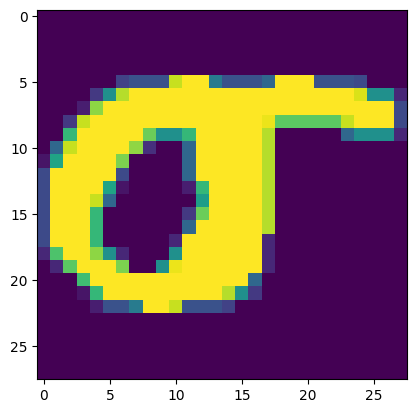

In [115]:
plt.imshow(chars[0][:,:,0])

In [116]:
model = tf.keras.models.load_model('./trained_model_letters_only')

In [117]:
raw_prediction = ""
predictions = model.predict(chars)

print(len(predictions[0]))

for prediction in predictions:
    #print(class_map[np.argmax(prediction)])
    
    print(np.argmax(prediction))
    raw_prediction += class_map[np.argmax(prediction)]
print(raw_prediction)

1/1 [==============================] - 0s 81ms/step
26
15
6
19
2
11
7
pgtclh


# Post processing

In [118]:
def tokens(text):
    "List all the word tokens (consecutive letters) in a text. Normalize to lowercase."
    return re.findall('[a-z]+', text.lower())

file = open("big.txt","r")
TEXT = file.read()

WORDS = tokens(TEXT)

COUNTS = Counter(WORDS)

def correct(word):
    "Find the best spelling correction for this word."
    # Prefer edit distance 0, then 1, then 2; otherwise default to word itself.
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

def known(words):
    "Return the subset of words that are actually in the dictionary."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Return all strings that are zero edits away from word (i.e., just word itself)."
    return {word}

def edits2(word):
    "Return all strings that are two edits away from this word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

def edits1(word):
    "Return all strings that are one edit away from this word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Return a list of all possible (first, rest) pairs that comprise word."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = 'abcdefghijklmnopqrstuvwxyz'

In [119]:
print(raw_prediction)
corrected_prediction = list(map(correct, tokens(raw_prediction)))[0]
#plt.imshow(image)
print(corrected_prediction)

pgtclh
pitch


In [120]:
count = 0

labels_file = open('labels.txt', 'r')
labels = labels_file.readlines()

for i in range(1000):
    print(str(i+1) + '/1000')
    label = labels[i].removesuffix('\n')
    img = 'emnist_words/word' + str(i) + '.png'
    #print(img)
    segments = word_segment(img)
    #print(segments.shape)
    for i in range(len(segments)):
        segments[i] = segments[i].transpose(1, 0, 2)
    raw_prediction = ""
    try:
        predictions = model.predict(segments)
        for prediction in predictions:
            raw_prediction += class_map[np.argmax(prediction)]
        corrected_prediction = list(map(correct, tokens(raw_prediction)))[0]
    except ValueError:
        print("Error with prediction: segmenting didn't return a char?")
    except IndexError:
        print("Error probably ocurred with processing (because no character was detected)")
    

    if corrected_prediction == label:
        count += 1
    print(raw_prediction + ' : ' + corrected_prediction + ' : ' + label)

print('================')
print('Accuracy: ' + str(count/1000))
    


1/1000
1/1 [==============================] - 0s 23ms/step
and : and : and
2/1000
1/1 [==============================] - 0s 32ms/step
trat : that : that
3/1000
1/1 [==============================] - 0s 35ms/step
pgtclh : pitch : pitch
4/1000
1/1 [==============================] - 0s 27ms/step
gnj : and : and
5/1000
1/1 [==============================] - 0s 25ms/step
pubepiisdjers : pubepiisdjers : publishers
6/1000
1/1 [==============================] - 0s 32ms/step
and : and : and
7/1000
1/1 [==============================] - 0s 25ms/step
geoeral : general : general
8/1000
1/1 [==============================] - 0s 35ms/step
s : s : s
9/1000
1/1 [==============================] - 0s 33ms/step
ij : in : is
10/1000
1/1 [==============================] - 0s 27ms/step
tnem : them : them
11/1000
1/1 [==============================] - 0s 64ms/step
mbvlemeat : mbvlemeat : movement
12/1000
1/1 [==============================] - 0s 31ms/step
runnong : running : running
13/1000
1/1 [============